In [ ]:
!wget -O 05_dtw_hmm.tgz https://www.fit.vutbr.cz/study/courses/ZRE/public/labs/05_dtw_hmm/05_dtw_hmm.tgz
!tar -xf 05_dtw_hmm.tgz


--2025-04-07 17:43:59--  https://www.fit.vutbr.cz/study/courses/ZRE/public/labs/05_dtw_hmm/05_dtw_hmm.tgz
Resolving www.fit.vutbr.cz (www.fit.vutbr.cz)... 2001:67c:1220:809::93e5:917, 147.229.9.23
Connecting to www.fit.vutbr.cz (www.fit.vutbr.cz)|2001:67c:1220:809::93e5:917|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.fit.vut.cz/study/courses/ZRE/public/labs/05_dtw_hmm/05_dtw_hmm.tgz [following]
--2025-04-07 17:43:59--  https://www.fit.vut.cz/study/courses/ZRE/public/labs/05_dtw_hmm/05_dtw_hmm.tgz
Resolving www.fit.vut.cz (www.fit.vut.cz)... 2001:67c:1220:809::93e5:941, 147.229.9.65
Connecting to www.fit.vut.cz (www.fit.vut.cz)|2001:67c:1220:809::93e5:941|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.fit.vut.cz/study/course/ZRE/public/labs/05_dtw_hmm/05_dtw_hmm.tgz [following]
--2025-04-07 17:43:59--  https://www.fit.vut.cz/study/course/ZRE/public/labs/05_dtw_hmm/05_dtw_hm

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal as sg
import scipy.stats as sts
import librosa
import soundfile as sf
from tqdm import tqdm
from IPython.display import Audio

# LAB 5  - DTW for speech recognition

## Ex. 1 Dynamic Time Warp
To compensate the time variability of phonetic instances ("dynamically") we look for the best possible time warping of the time axis.

### 1.0. Prepare the training and testing sets
We have 4 training sequences and 7 testing sequences. We use the training ones to train the model. Then we use the testing ones to check the quality of our model.


In [ ]:
def frame(wavname, ls, rs, Fs):
    # load
    s = librosa.load(wavname, sr = Fs)[0]
    sm = s - np.mean(s)
    # divide signal into frames
    hopsize = ls - rs
    Nram = int(1 + np.floor((len(sm) - ls) / hopsize))
    xram = np.array([sm[i*hopsize:i*hopsize + ls] for i in range(Nram)])
    return xram
ls = 240
rs = 160
Fs = 8000
train_orig = {}
train_orig["1"] = librosa.load('05_dtw_hmm/1.wav', sr = Fs)[0]
train_orig["2"] = librosa.load('05_dtw_hmm/2.wav', sr = Fs)[0]
train_orig["3"] = librosa.load('05_dtw_hmm/3.wav', sr = Fs)[0]
train_orig["4"] = librosa.load('05_dtw_hmm/4.wav', sr = Fs)[0]

train = {}
train["1"] = frame('05_dtw_hmm/1.wav', ls, rs, Fs)
train["2"] = frame('05_dtw_hmm/2.wav', ls, rs, Fs)
train["3"] = frame('05_dtw_hmm/3.wav', ls, rs, Fs)
train["4"] = frame('05_dtw_hmm/4.wav', ls, rs, Fs)

Audio('05_dtw_hmm/2.wav', rate = 8000)

# Audio(05_dtw_hmm/2.wav, rate=8000)
# Audio(05_dtw_hmm/3.wav, rate=8000)
# Audio(05_dtw_hmm/4.wav, rate=8000)

In [ ]:
# testing set

test_orig = {}
test_orig["1t"] = librosa.load('05_dtw_hmm/1t.wav', sr = Fs)[0]
test_orig["2t"] = librosa.load('05_dtw_hmm/2t.wav', sr = Fs)[0]
test_orig["3t"] = librosa.load('05_dtw_hmm/3t.wav', sr = Fs)[0]
test_orig["4t"] = librosa.load('05_dtw_hmm/4t.wav', sr = Fs)[0]
test_orig["1l"] = librosa.load('05_dtw_hmm/1l.wav', sr = Fs)[0]
test_orig["2l"] = librosa.load('05_dtw_hmm/2l.wav', sr = Fs)[0]
test_orig["b"] = librosa.load('05_dtw_hmm/b.wav', sr = Fs)[0]

test = {}
test["1t"] = frame('05_dtw_hmm/1t.wav', 240, 160, Fs = 8000)
test["2t"] = frame('05_dtw_hmm/2t.wav', 240, 160, Fs = 8000)
test["3t"] = frame('05_dtw_hmm/3t.wav', 240, 160, Fs = 8000)
test["4t"] = frame('05_dtw_hmm/4t.wav', 240, 160, Fs = 8000)
test["1l"] = frame('05_dtw_hmm/1l.wav', 240, 160, Fs = 8000)
test["2l"] = frame('05_dtw_hmm/2l.wav', 240, 160, Fs = 8000)
test["b"] = frame('05_dtw_hmm/b.wav', 240, 160, Fs = 8000)

Audio('05_dtw_hmm/2t.wav', rate = 8000)

### 1.1 Calculate LPC coefficients and transform them into **cepstral** coefficients:

from lecture on LPC : [ppt](img\\lpcc.PNG) and [ppt2](img\\LPCCcoeff.png)

$$ c(n) = {\it F}^{-1}[\ln G_{LPC}(f)] $$

1) $$c(0) =  \ln G^2$$

2) $$ c(n) = -a_n - \frac{1}{n}\displaystyle\sum_{k=1}^{n-1}k\;c_k\;a_{n-k}$$
    for $1\leq n \leq P$


In [ ]:
def lpc_coefficients(frame, P):
    R = np.array([np.sum(frame[i:] * frame[:len(frame)-i]) for i in range(P+1)])
    A = np.hstack([[1], np.linalg.inv(scipy.linalg.toeplitz(R[:-1])) @ -R[1:]])

    return A # shape (P+1)

def LPCC(sig_frames, P):
    # P: order of LPC (10)
    LPC = np.array([lpc_coefficients(fr, P) for fr in sig_frames]) # matrix of LPC coefficients, shape: (N,P+1)
    LPC_cepstral = []
    N = P+1

    for frame in range(0, len(sig_frames)):
        c = np.zeros((N+1))
        a = LPC[frame]
        ahelp = np.hstack([a, np.zeros(N - len(a))])
        c[1] = - ahelp[1]
        for n in range(2, N):
            k_s = np.arange(1, n-1)
            c_k_s = c[1:n-1]
            a_n_s = ahelp[n-k_s]
            som = np.sum(k_s*c_k_s*a_n_s)/n
            c[n] = -ahelp[n] - som

        #print(c.shape)
        LPC_cepstral.append(c[1:-1])

    print(np.array(LPC_cepstral).shape)

    return np.array(LPC_cepstral)

print("test vectors shapes")
LPCCr = [LPCC(sig, P = 10) for sig in train.values()]
LPCC_train = {k: v for k,v in zip(train.keys(), LPCCr)}

print("Test vectors shapes")
LPCCs = [LPCC(sig, P = 10) for sig in test.values()]
LPCC_test = {k: v for k,v in zip(test.keys(), LPCCs)}


test vectors shapes
(55, 10)
(40, 10)
(36, 10)
(49, 10)
Test vectors shapes
(47, 10)
(38, 10)
(30, 10)
(51, 10)
(64, 10)
(80, 10)
(44, 10)


### 1.2 Define the trajectory for one word
We want to know to which of the train words the test word is closer, but the length of the word vectors are not the same (each word has different length).

To calculate the distance between two words we consider the distances between each frame **one vector of length P ( = 10) per frame**.

Algorithm from lecture: [DTW](img\\DTW.PNG)

#### 1.2.1 Define the word matrices and distances:
1) Test word:

    **o = $LPCC\{x_{test}\}$** ---> shape: (T, P), where T is length of test vector (n. of frames)

2) Train word:

    **r = $LPCC\{x_{train}\}$** ---> shape: (R, P), where R is length of train vector

3) Distance:

    $d(x_o, x_r) = \sqrt{\sum_{i=1}^{P} \|x_o[i]-x_r[i]\|^2}$

    where $x_o, x_r$ are frames respectively of the test vector **o** and of the train vector **r**



In [ ]:
r = LPCC_train["1"] #(55,11)
R = r.shape[0]

o = LPCC_test["1t"] #(47,11)
T = o.shape[0]

P = o.shape[1]
dist = np.zeros((T, R))

#dist[idx_o, idx_r] # list of distances between all frames

print(dist.shape) # TxR
dist


(47, 55)


array([[ 0.32036201,  0.47645104,  0.8730478 , ...,  0.77519758,
         0.85118152,  0.64171519],
       [ 1.67825351,  1.24269808,  1.43902513, ...,  1.8774548 ,
         1.94963564,  1.69055782],
       [ 1.65862477,  1.25242562,  1.49139841, ...,  1.8857018 ,
         1.96953672,  1.6793044 ],
       ...,
       [23.41711926, 23.63741459, 23.21607262, ..., 23.7342017 ,
        23.75686608, 23.64204443],
       [ 7.42219273,  7.80747456,  7.90226193, ...,  7.71239643,
         7.66430722,  7.64452685],
       [ 2.62826863,  2.93499687,  3.22419103, ...,  2.37944352,
         2.33810355,  2.62142865]])

#### 1.2.2 Matrix of costs G - partial cumulative distances

$$G(\mathbf{o},\mathbf{r}) =
\begin{bmatrix}
g_{0,0} & g_{1,0} & ... & g_{0,R}\\
...\\
g_{T,0} & g_{T,1} & ... & g_{T,R}
\end{bmatrix}
$$
where $g_{i,j}$ is the cost of the ${i,j}$ step:
$$ g(i,j) = \min \left\{
\begin{align*}
& d(i,j) + g(i−1,j)\\
& d(i,j) + g(i,j−1)\\
& d(i,j) + g(i−1,j−1)\\
\end{align*}
\right.\\
1\leq i\leq T\quad\quad 1\leq j\leq R
$$

Initialize:
$$ g(0, 0) = 0$$
$$g(0,j) = \infty$$
$$g(j,0) = \infty$$


In [ ]:
# INIT
g = np.zeros((T+1, R+1))
g[0,1:] = np.Inf
g[1:,0] = np.Inf
print(g)


[[ 0. inf inf ... inf inf inf]
 [inf  0.  0. ...  0.  0.  0.]
 [inf  0.  0. ...  0.  0.  0.]
 ...
 [inf  0.  0. ...  0.  0.  0.]
 [inf  0.  0. ...  0.  0.  0.]
 [inf  0.  0. ...  0.  0.  0.]]


In [ ]:
#g = np.zeros((T+1, R+1))
directions = np.zeros((T+1,R+1))
for idx_o in range(0, T):
    for idx_r in range(0, R):
        d = ##
        w = ##  #symmetrical W_k

        g_prev =  # Idxs shifted by one because of structure of g

        g[idx_o+1, idx_r+1] = ##
        directions[idx_o+1, idx_r+1] = ##

print(g)
print(directions)

[[  0.                  inf          inf ...          inf          inf
           inf]
 [         inf   0.64072403   1.11717507 ... 111.16825794 112.01943946
  112.66115466]
 [         inf   2.31897754   2.35987315 ... 113.04571275 113.9690751
  114.35171248]
 ...
 [         inf 188.36300198 180.69571565 ... 189.12399182 189.7322392
  189.99441699]
 [         inf 195.78519471 188.50319021 ... 196.83638826 197.39654642
  197.63894384]
 [         inf 198.41346335 191.43818708 ... 195.32696241 197.66506595
  200.26037249]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 2. ... 2. 2. 2.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 2. 2. 0.]]



#### 1.2.3 Calculate the minimal normalized cumulative distance:
$$
D(\mathbf{O},\mathbf{R}) =\frac{g(T,R)}{T+R}
$$

In [ ]:
D = g[-1,-1]/(T+R)
print(D)


1.9633369851701914


#### Q: When is it zero? Why?

#### 1.2.4 Draw the trajectory of the DTW
Get the list of points to draw the DTW trajectory. Start from the last point (coordinates [T,R]) and then proceed according to the chosen predecessor (array *directions*)

In [ ]:
max_idx = np.min([T,R])
traj = np.zeros((max_idx, 2))
traj[0,:] = [T-1,R-1]
#traj = [[T,R]] # to get the list of points in the trajectory start from the end
direction = directions[-1,-1]

for i in range(0,max_idx-1):
    actual = traj[i,:]
    # translate the direction index 0,1,2 according to the calculation of g:
    #g_prev = np.array([g[idx_o-1, idx_r], g[idx_o-1, idx_r-1], g[idx_o, idx_r-1]])
    if direction == 0:
        next = #
    elif direction == 1:
        next = #
    elif direction == 2:
        next = #
    else:
        next = #

    next = [int(_) for _ in next]
    direction = directions[next[0], next[1]]
    traj[i+1,0] = next[0]
    traj[i+1,1] = next[1]

traj = np.array(traj)[::-1]

C:\Users\uzivatel\AppData\Local\Temp\ipykernel_42164\2604277244.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


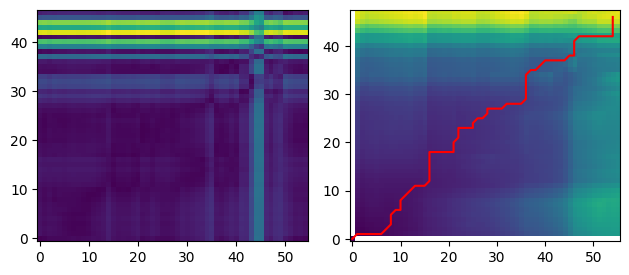

In [ ]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(dist, origin='lower')
ax[1].imshow(g, origin='lower')
ax[1].plot(traj[:,1], traj[:,0], c='r')
fig.tight_layout()
fig.show()

In [ ]:
def DTW(r, o, plots = True): # r: train sample, o: test sample

    ### PASTE YOUR SOLUTION HERE.


    if plots:
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(dist, origin='lower')
        ax[1].imshow(g, origin='lower')
        ax[1].plot(traj[:,1], traj[:,0], c='r')
        fig.tight_layout()
        fig.show()

    return D, traj

### 1.3 Compare Test and Train samples
Let's use the DTW calculation to compare samples.



#### 1.3.1 Same sample

0.0


C:\Users\uzivatel\AppData\Local\Temp\ipykernel_42164\2869532277.py:61: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


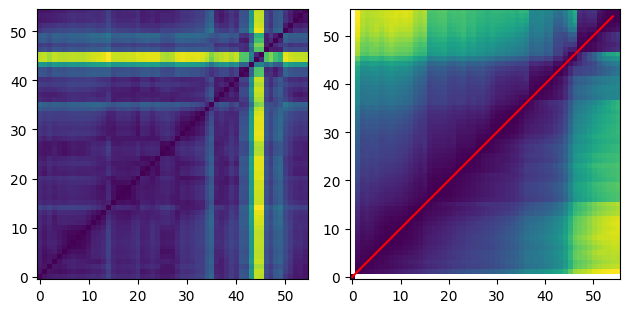

In [ ]:
D, traj = DTW(LPCC_train["1"], LPCC_train["1"], True)
print(D)

#### Q: Why is the line straight?

#### Q: What is the "four-leaf clover" in the last samples (45..55)?

#### 1.3.2 Same word, different sample

1.9633369851701914


C:\Users\uzivatel\AppData\Local\Temp\ipykernel_42164\2869532277.py:61: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


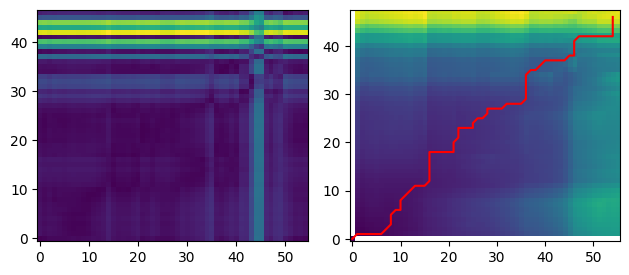

In [ ]:
D, traj = DTW(LPCC_train["1"],LPCC_test["1t"], True)
print(D)

In [ ]:
Audio(train_orig["1"], rate = Fs)

In [ ]:
Audio(test_orig["1t"], rate = Fs)

#### 1.3.3 Tests

C:\Users\uzivatel\AppData\Local\Temp\ipykernel_42164\2869532277.py:61: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


1.1159703299912027


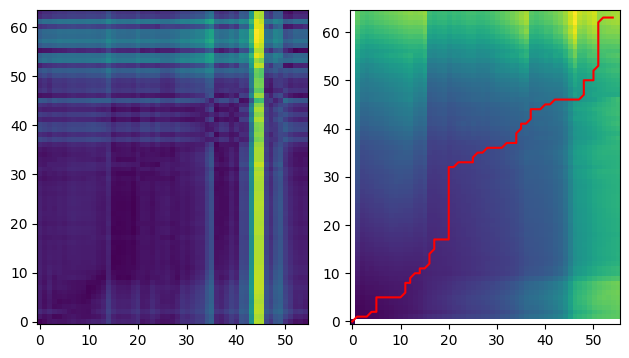

In [ ]:
D, _ = DTW(LPCC_train["1"],LPCC_test["1l"], True)
print(D)

#### Q: How is the "1l" sample compared to the train "1"? Can you see it in the trajectory?

In [ ]:
Audio(test_orig["1l"], rate = Fs)

#### Q: What is the DTW distance? What does it tell you?


0.639428812872421


C:\Users\uzivatel\AppData\Local\Temp\ipykernel_42164\2869532277.py:61: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


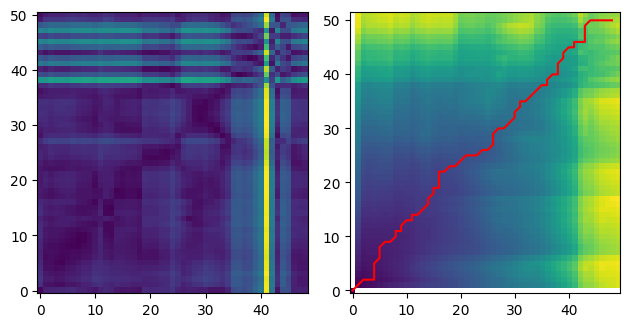

In [ ]:
D, _ = DTW(LPCC_train["4"],LPCC_test["4t"],  True)
print(D)

### 1.3.4 Word recognition
Take a test sammple and compare it to the train samples to decide which one it is. You need to compare the D values to do so. Let's try to recognize the test sample nr. 2.

C:\Users\uzivatel\AppData\Local\Temp\ipykernel_42164\2869532277.py:61: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


[1.1407913912866772, 0.6453855679652525, 0.7599831833448107, 0.9298928835564267]


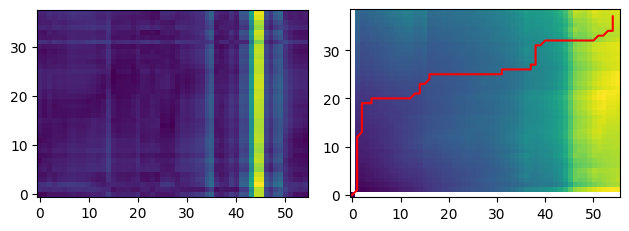

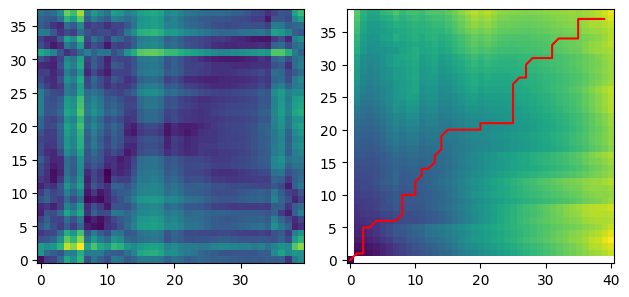

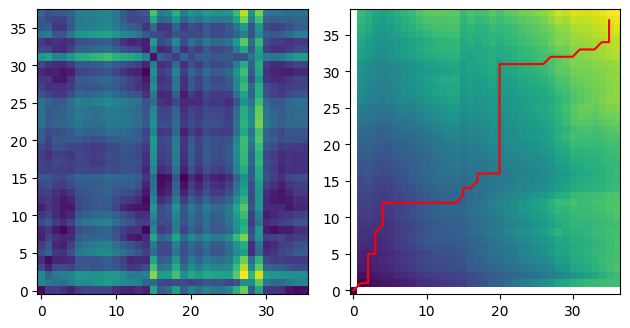

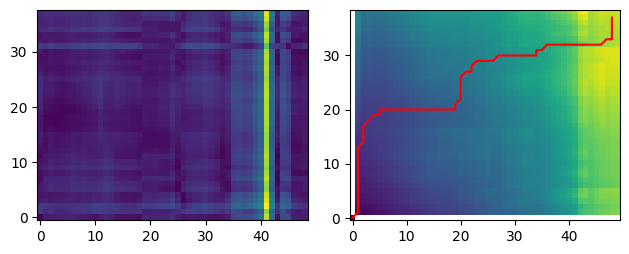

In [ ]:
distances2 = []
for i in range(1,5):
    D, _ = DTW(LPCC_train[str(i)],LPCC_test["2t"],True)
    distances2.append(D)

print(distances2)

In [ ]:
recognized = np.argmin(distances2) + 1
print(f'The "2t.wav" sample is closer to : saple nr. {recognized} from the train set')

The "2t.wav" sample is closer to : saple nr. 2 from the train set


#### Q: Check the trajectories. What are the vertical lines related to? Listen to the Audio.

C:\Users\uzivatel\AppData\Local\Temp\ipykernel_42164\2869532277.py:61: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Rozpoznano ======= p_cb: 3 ========


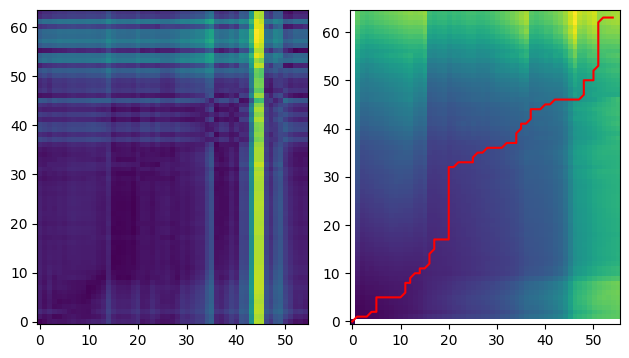

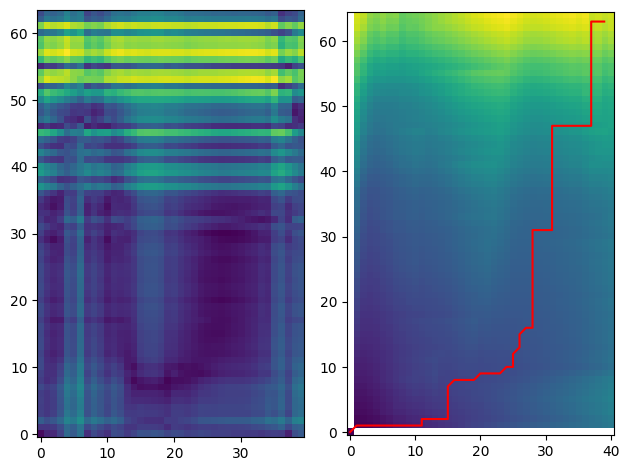

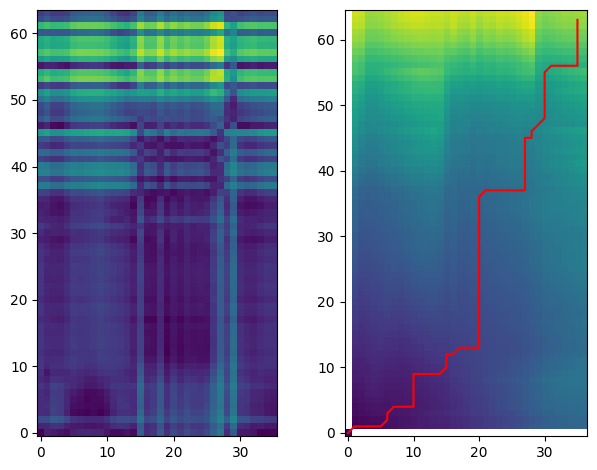

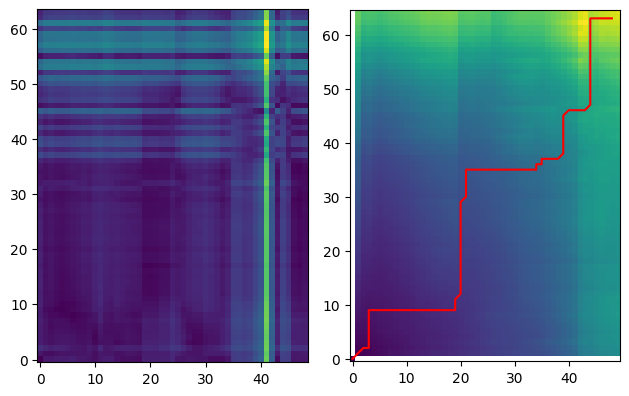

In [ ]:
distances = []
for i in range(1,5):
    D,_ = DTW(LPCC_train[str(i)], LPCC_test["1l"], True)
    distances.append(D)
    chosen = np.argmin(distances) + 1

print(f'Rozpoznano ======= p_cb: {chosen} ========')

C:\Users\uzivatel\AppData\Local\Temp\ipykernel_42164\2869532277.py:61: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Recognized ======= p_cb: 2 ========


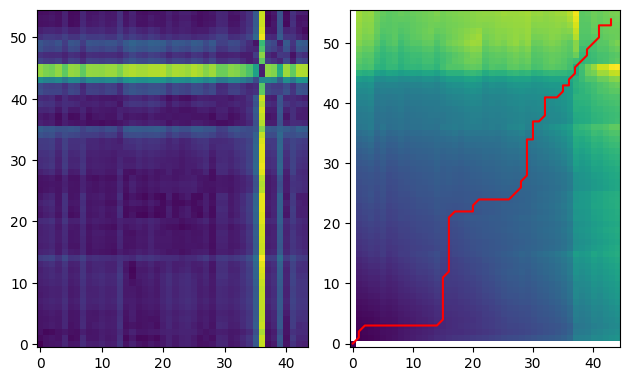

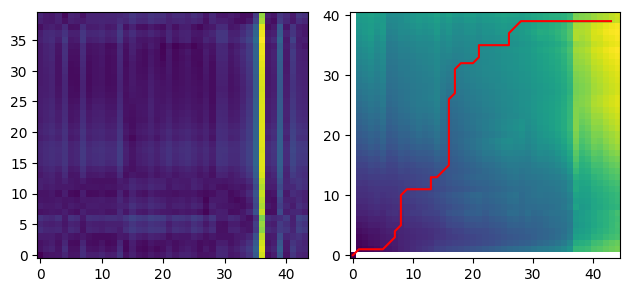

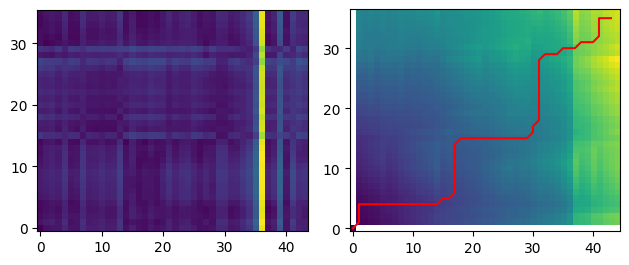

In [ ]:
distances = []
for i in range(1,4):
    D,_ = DTW(LPCC_test["b"], LPCC_train[str(i)], True)
    distances.append(D)
    chosen = np.argmin(distances) + 1

print(f'Recognized ======= p_cb: {chosen} ========')

#### Q: Do you think that DTW will have a 100% success rate in case of more complex inputs (noise, multi-channel, multi-speaker)? Guess the error rate of the english speech recognition systems (meetings, calls)